### This is the code that uploads an image, demages it using a mask (that it also uploads) and than solves a Laplace equation with the boudnary conditions on the border on the image to restore the original image. Solution using the Jocobi method. Solution available for both color image and for grayscale
#### Contents:
* First we upload the images and damage the original
* Find the boundary region next to the damaged region in the image
* Define initial conditions and the Jacobi solver
* Run the Jacobi solver and plot
* Check convergance for the grayscale image
* Calculate $\chi^2$ value for the most intersting regions

#### Prerequisites:
* Package *pillow* \
Follow:
https://pillow.readthedocs.io/en/stable/installation.html

In [1]:
# %matplotlib widget #If viewed in Jupyter lab
%matplotlib notebook

from PIL import Image
import numpy as np
import sys
from matplotlib import pyplot as plt
# For printing out all the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Create grayscale image
*  Upload an image and the mask. Then convert image to both grayscale and RGB. Afterwards damage the image. Bellow will be a plot of the images
* Define *IfColor* variable which:  = 0, if we want to calculate only grayscale, or =1, if calculate both color and grayscale

In [2]:
IfColor = 1 #=1 if calc. for color image as well

img = Image.open('Pics\serveimage.jpg', mode='r')
Mask = Image.open('Pics\TheMask.png', mode='r').convert('L')

I = np.asarray(img.convert('L')).copy()  # Copy so that you can update the file
MaskMat = np.asarray(Mask).copy()

#Color image
IColor = np.asarray(img).copy()

#Change MaskMat to black & white
MaskMat[MaskMat < 128] = 0    # Black
MaskMat[MaskMat >= 128] = 255  # White
IDam = I.copy()
IDam[MaskMat == 0] = 0
IColor[MaskMat == 0,:] = 0

#Splin into RGB
IRed = IColor[:,:,0]
IGreen = IColor[:,:,1]
IBlue = IColor[:,:,2]

### Define the positions of the demaged regions and boundary conditions
* We find the outer border of the demage and define the boundary values "bc" to have the value 0 everywhere excpet on the boundary. But on the boundary bc the internsity value of the not damaged image

In [3]:
from PIL import ImageFilter
import PIL.ImageOps

# This gives the outer border - where we can take the border conditions
borderInv1 = PIL.ImageOps.invert(Mask).filter(ImageFilter.CONTOUR)
borderInv = np.asarray(borderInv1)

bc = np.zeros([len(I), len(I[1])])
bc[borderInv != 255] = IDam[borderInv != 255]
bc[:, [0, -1]] = 0  # Otherwise there are problems at the border of the image
bc[[0, -1], :] = 0

#### Possible to check the boundary if it is obtained correctly

In [4]:
# border1 = Mask.filter(ImageFilter.CONTOUR)  # iner border. Don't need anymore
# border = np.asarray(border1)

# Check with the plot above if the border lies where it should
# I[borderInv == 0] = 255
# I[border == 0] = 0
# plt.imshow(I, cmap='gray', interpolation='nearest')

# Another check
# np.max(I[borderInv == 0]) #The value is not 255 which means that it is not the border - black

### Plot of the damaged grayscale + colored image
Possible to plot the boundary, if uncomment the last line

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10.3, 6.8)
ax1.imshow(IDam, cmap='gray', interpolation='nearest')
ax2.imshow(IColor, cmap='gray')
#ax2.imshow(bc, cmap='gray')   #Uncomment to see the border

<IPython.core.display.Javascript object>

## Begin the Jecobi method
### Define the *initial values* for all internsities inside as the average of the boundary
### Also define the number of interations

In [32]:
NIter = 20 #How many time to iterate
IfSkip = np.array([[0]*len(I[0])]*len(I))
IfSkip[IDam != 0] = 1

Pts0 = np.array([[-1]*len(I[0])]*len(I))
Pts0[IDam == 0] = np.mean(bc[borderInv != 255])
Pts0[bc != 0] = I[bc != 0]

InnerPts = np.array([Pts0]*(NIter+1)).astype(np.float64)

### Repeat for the Red, Blue, Green

In [34]:
# [InnerR,InnerB, InnerG] = np.zeros((3, NIter, len(I), len(I[0])))
[InitR, InitB, InitG] = np.zeros((3, len(I), len(I[0])))
InitR[IDam == 0] = np.mean(IRed[borderInv != 255])
InitB[IDam == 0] = np.mean(IBlue[borderInv != 255])
InitG[IDam == 0] = np.mean(IGreen[borderInv != 255])

InitR[bc != 0] = IRed[bc != 0]
InitB[bc != 0] = IBlue[bc != 0]
InitG[bc != 0] = IGreen[bc != 0]


#InnerR = np.append([InitR], InnerPts, axis=0)
InnerR = np.array([InitR]*(NIter+1))
InnerB = np.array([InitB]*(NIter+1))
InnerG = np.array([InitG]*(NIter+1))

### Define the Jacoby solver

In [35]:
N2d = 4
NB = 0  # Nr of vonNeuman boundaries

def JacobyMeth(t, j, k, List, *args):
    InnerP = List
    uNeigh = [InnerP[t, j-1, k], InnerP[t, j+1, k],InnerP[t, j, k-1], InnerP[t, j, k+1]]
    InnerP[t+1, j, k] = 1/(N2d-NB)*(sum(uNeigh))  # +rho=0

### Run iterations
* takes 15 seconds for 20 iterations

In [36]:
%%time
if IfColor:
    ColorList = [InnerPts,InnerR, InnerB,InnerG]
else:
    ColorList = [InnerPts]

    
for List in ColorList:
    for t in range(NIter):
        # -1 because otherwise there are errors in when looking at the postition to the right.
        # There are anyway no changes at the right border
        for j in range(len(InnerPts[0])-1):   
            for k in range(len(InnerPts[0][0])-1):
                if IfSkip[j,k]:
                    continue
                JacobyMeth(t, j, k, List)

Wall time: 12.9 s


### Plot the result

* The grayscale result. On the left - after, on the right - before

<IPython.core.display.Javascript object>


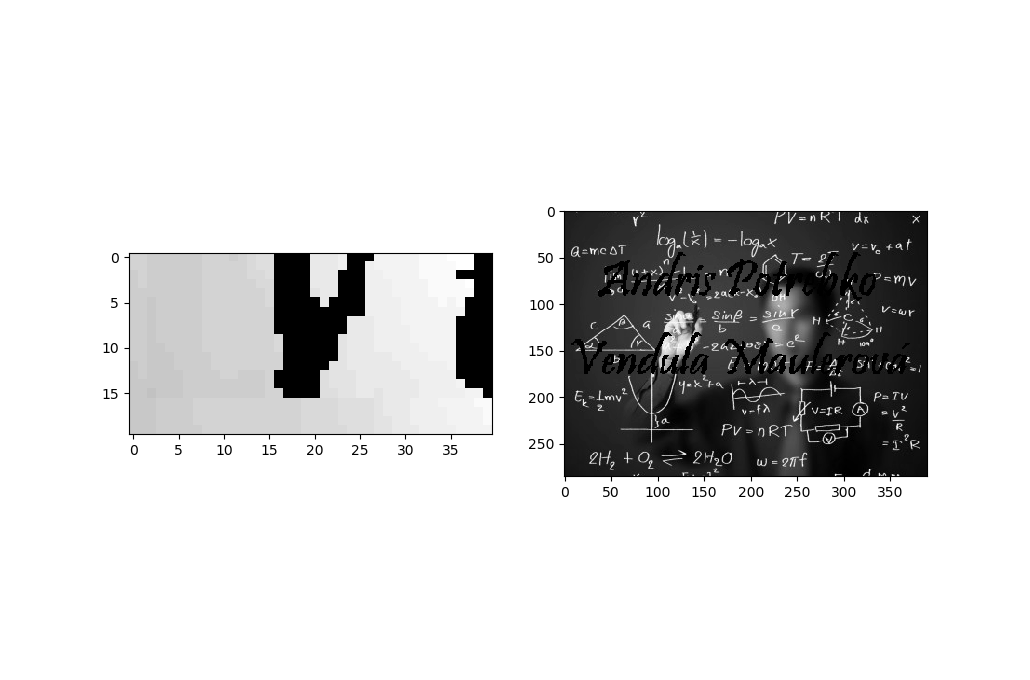

In [41]:
IRes=IDam.copy()
IRes[MaskMat == 0] = InnerPts[NIter][MaskMat == 0] 
fig2, (ax3,ax4) = plt.subplots(1,2)
fig2.set_size_inches(10.3, 6.8)
ax3.imshow(IRes, cmap='gray', interpolation='nearest')
ax4.imshow(IDam, cmap='gray', interpolation='nearest')
#ax3.imshow(InnerPts[1], cmap='gray', interpolation='nearest')

* Plot Color result

<IPython.core.display.Javascript object>


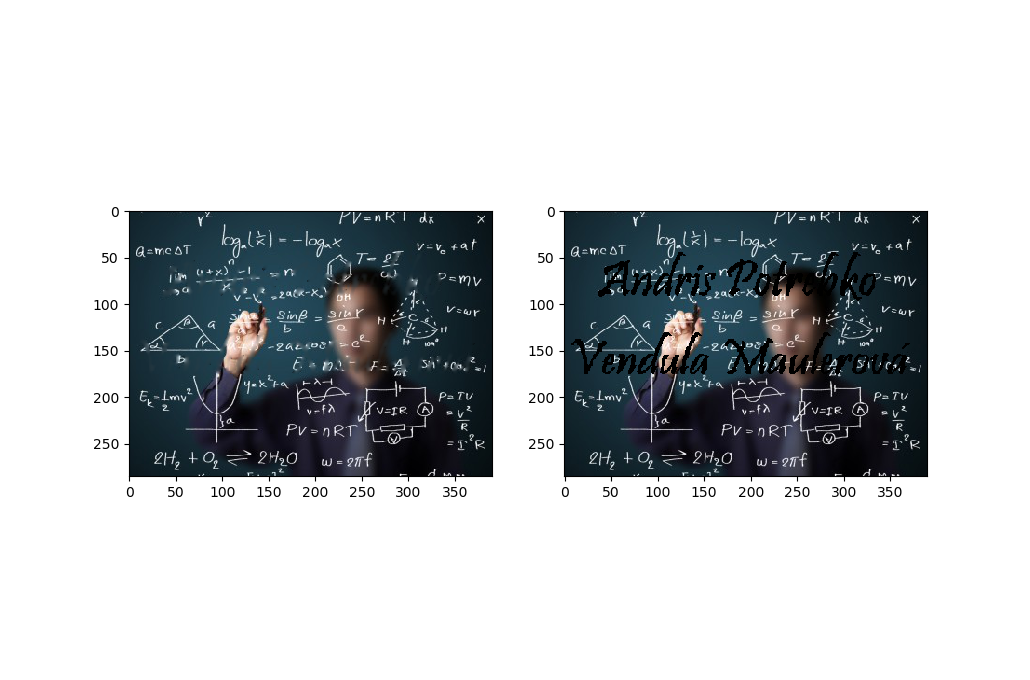

In [42]:
IResC=IColor.copy()
IResC[MaskMat == 0,0] = InnerR[NIter][MaskMat == 0] 
IResC[MaskMat == 0,1] = InnerG[NIter][MaskMat == 0] 
IResC[MaskMat == 0,2] = InnerB[NIter][MaskMat == 0] 
fig3, (ax5,ax6) = plt.subplots(1,2)
fig3.set_size_inches(10.3, 6.8)
ax5.imshow(IResC, cmap='gray', interpolation='nearest')
ax6.imshow(IColor, cmap='gray', interpolation='nearest')

### Check the convergance

<IPython.core.display.Javascript object>


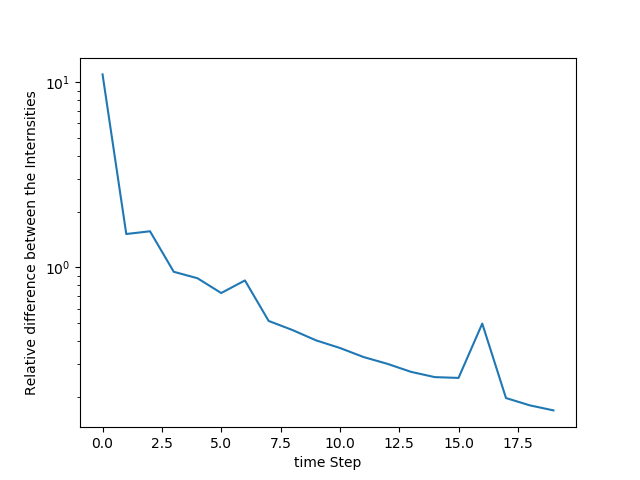

[Text(0, 0.5, 'Relative difference between the Internsities'),
 Text(0.5, 0, 'time Step')]

In [48]:
InnerP = InnerPts
Conv = [0]*(len(InnerP)-1)
n=len(IDam)
for i in range(len(InnerP)-1):
    Conv[i]=np.sum( np.abs((InnerP[i+1]-InnerP[i])/(InnerP[i+1]+0.001)) )/n
fig3, ax4 = plt.subplots()
ax4.set(xlabel='time Step',
       ylabel='Relative difference between the Internsities')
ax4.set_yscale('log')
ax4.plot(Conv)

In [49]:
# np.std(I)**2
# np.sum((np.mean(I)-I)**2)/(len(I)*len(I[0]-1))
sigI = np.std(IDam)**2
Ksi2 = 1/n * np.sum((IRes-I)**2 ) / sigI**2
Ksi2
#len(I)
#I[MaskMat == 0]

0.00034345986440135296

### Comparison between $\chi^2$ squares at different image locations
* In the first line define pixels that want to analyze and then run the function for calculating $\chi^2$ for any location. We define 8 vectors with the corders of the pixel numbers for each of the interesting regions. The first part of the name of the vector means the letters from the Mask that we are looking at. For example AnCo means that we are looking at the damage where the Mask makes two letters "An"


* First we notice that $\chi^2$ is larger for VCo3 - where we look at the damage at the plain background. And it is larger than for highly changing background like VCo2. It might seem that it does not make sense because the highly changing background is appearantly worse recovered. You can see it by naked eye. But what causes this effect is the division by $\sigma^2$ in the $\chi^2$, which normalises the result by how changing is the result. Thus, the good result for VCo2 actually shows that the method is good at recovering also the chaning background

* The worst result of the rest is than for *An* part which has many different small changes in the background


In [52]:
AnCo = [50,30,94,96]
MaCo = [130, 170, 180, 240]
KoCo= [40,295,100,340]
dCo = [130,85,180,115]
VCo=[135,5,155,45]
VCo2 = [135,5,180,45]
VCo3 = [160,5, 180, 45]
WholeCo = [0,0,220,340]

def FindKsi(Co, *args):
    Itemp = I[Co[0]:Co[2],Co[1]:Co[3]]
    MaskTemp = MaskMat[Co[0]:Co[2],Co[1]:Co[3]]
    ResTemp = IRes[Co[0]:Co[2],Co[1]:Co[3]]
#     Idamag = Itemp[MaskTemp == 0]
    sigI = np.std(IDam)**2
#     n=len(Idamag)
    Ksi2 = 1/n * np.sum((ResTemp-Itemp)**2 ) / sigI**2
    print("SigI = ",sigI, " Ksi2 = ", Ksi2)
#     return Ksi2

FindKsi(AnCo)
FindKsi(MaCo)
FindKsi(KoCo)
FindKsi(dCo)
FindKsi(WholeCo)
FindKsi(VCo)
FindKsi(VCo2)
FindKsi(VCo3)

SigI =  2014.2788385367955  Ksi2 =  3.1669861122841075e-05
SigI =  2014.2788385367955  Ksi2 =  4.868567684204647e-05
SigI =  2014.2788385367955  Ksi2 =  2.1505860200508227e-05
SigI =  2014.2788385367955  Ksi2 =  2.2159649420050782e-05
SigI =  2014.2788385367955  Ksi2 =  0.0003260367276207659
SigI =  2014.2788385367955  Ksi2 =  1.0400956274389275e-05
SigI =  2014.2788385367955  Ksi2 =  1.0914647804029851e-05
SigI =  2014.2788385367955  Ksi2 =  4.6180349634354973e-07
